In [6]:
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.layers as layers
from scripts.utils import *
from scripts.models import *
from scripts.rigid_transform import *
from scripts.loss import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [3]:
size_img=(256, 256)
data = load_masks("data/vessel_only/",target_size=size_img)
train, test = split_dataset(data,balance=0.9,seed=120)
print(f"We have {train.shape[0]} training image pairs and {test.shape[0]} test image pairs.")

We have 2143 training image pairs and 239 test image pairs.


In [6]:
type(train)

tensorflow.python.framework.ops.EagerTensor

In [4]:
u = cv2.resize(np.asarray(train[1][0][:,:,0]),size_img)
v = cv2.resize(np.asarray(train[1][1][:,:,0]),size_img)
show_images([u,v])

# Training

In [6]:
def training(train_data,epochs,batch_size,lr,size_img):
    # Shuffle and batch the dataset.
    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    x_train = from_tensor_slices(train).shuffle(10000).batch(batch_size)
    model = model_extended(input_shape=size_img+(1,))#simple_cnn(input_shape=size_img+(1,))
    # optimizer set up
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    criterion = ncc_loss
    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    for epoch in range(epochs):
        m_train.reset_states()
        for i, pair in enumerate(x_train):
            moving = pair[:,0,:,:,:]
            static = pair[:,1,:,:,:]
            #print(type(moving), moving.shape, type(static), static.shape)
            #show_images([moving[0],static[0]])
            loss_train = train_step(model, moving, static, criterion,
                                    optimizer)
            m_train.update_state(loss_train)
        print('Epoch: %3d/%d\tTrain Loss: %.6f'
              % (epoch + 1, epochs, m_train.result()))
    print('\n')
    return model

In [7]:
epoch = 200
batch_size = 8
lr = 0.01
model_post_training = training(train,epoch,batch_size,lr,size_img)

(None, 8, 8, 2)
(None, 8, 8, 2)
(None, 3)
Epoch:   1/200	Train Loss: -0.108758
Epoch:   2/200	Train Loss: -0.112976
Epoch:   3/200	Train Loss: -0.113360
Epoch:   4/200	Train Loss: -0.106866
Epoch:   5/200	Train Loss: -0.111818
Epoch:   6/200	Train Loss: -0.109233
Epoch:   7/200	Train Loss: -0.111915
Epoch:   8/200	Train Loss: -0.108933
Epoch:   9/200	Train Loss: -0.108980
Epoch:  10/200	Train Loss: -0.109463
Epoch:  11/200	Train Loss: -0.110482
Epoch:  12/200	Train Loss: -0.110282
Epoch:  13/200	Train Loss: -0.107488
Epoch:  14/200	Train Loss: -0.110199
Epoch:  15/200	Train Loss: -0.108150
Epoch:  16/200	Train Loss: -0.111534
Epoch:  17/200	Train Loss: -0.106740
Epoch:  18/200	Train Loss: -0.113003
Epoch:  19/200	Train Loss: -0.107903
Epoch:  20/200	Train Loss: -0.113137
Epoch:  21/200	Train Loss: -0.104760
Epoch:  22/200	Train Loss: -0.109766
Epoch:  23/200	Train Loss: -0.111597
Epoch:  24/200	Train Loss: -0.111686
Epoch:  25/200	Train Loss: -0.109154
Epoch:  26/200	Train Loss: -0.107

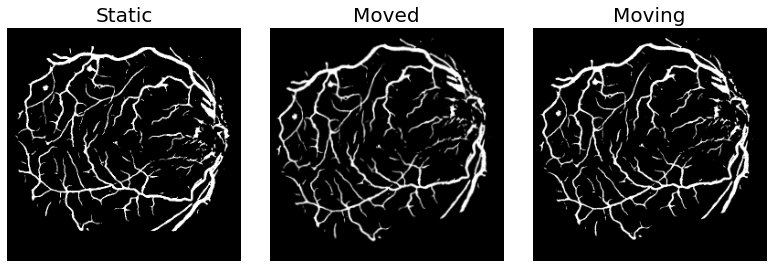

In [12]:
i = 5
output_net = model_post_training({'moving': test[i][1:], 'static': test[i][:1]}, training=False)    
M = build_transformation_matrix(output_net)
moved = apply_transformation_matrix(M, test[i][1:])
plot_images2(moved,test[i][1:],test[i][:1])

---